In [6]:
from regions import Regions
import numpy as np
from regions import PixCoord
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

import Paths.Paths as paths
Path = paths.filepaths()

w51e_b6_reg = Regions.read('w51e2_1mm')
w51n_b6_reg = Regions.read('w51n_1mm')
w51e_b3_reg = Regions.read('w51e2_3mm')
w51n_b3_reg = Regions.read('w51n_3mm')




In [7]:
print(w51e_b6_reg)


[<PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.92995387, 14.51389255)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.92995813, 14.51407836)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93008111, 14.51405152)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93013158, 14.51397651)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93093012, 14.51402018)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93246682, 14.51304212)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93241348, 14.51275666)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93153796, 14.51249254)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.93171663, 14.51214783)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
    (290.9295818, 14.51151094)>)>, <PointSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
  

In [8]:
from regions import CirclePixelRegion
from radio_beam import Beam
import astropy.units as u
def compare_with_initial_dendro(init_dendro, regs, wcs, beam):
    pixcoords = PixCoord(init_dendro['peak_x'], init_dendro['peak_y'])

    selected_regs = []
    unselected_regs = []
    selected_peaks_x = []
    selected_peaks_y = []
    pixel_scale = wcs.proj_plane_pixel_scales()[0]

    for reg in regs:
        reg_pix = reg.to_pixel(wcs)
        reg_pix_circle = CirclePixelRegion(reg_pix.center, radius=(beam.major/pixel_scale).to(u.pix/u.pix).value)
        if any(reg_pix_circle.contains(pixcoords)):
            selected_regs.append(reg_pix_circle)

            iscontain = reg_pix_circle.contains(pixcoords)
            selected_peak_x = init_dendro['peak_x'][iscontain]
            selected_peak_y = init_dendro['peak_y'][iscontain]
            selected_peak_value = init_dendro['peak_value'][iscontain]
            if len(selected_peak_x) > 1:
                maxind = np.argmax(selected_peak_value)
                selected_peaks_x.append(selected_peak_x[maxind].item())
                selected_peaks_y.append(selected_peak_y[maxind].item())
            elif len(selected_peak_x) == 1:
                selected_peaks_x.append(selected_peak_x.item())
                selected_peaks_y.append(selected_peak_y.item())


        else:
#            print('not matched with dendro')
            unselected_regs.append(reg_pix_circle)
    print(f'Number of selected regions: {len(selected_regs)}')
    print(f'Number of unselected regions: {len(unselected_regs)}')
    print(f'Number of total regions: {len(regs)}')
    print(f'Number of selected initial dendrogram peaks: {len(selected_peaks_x)}')
    print(f'Number of initial dendrogram peaks: {len(init_dendro)}')
    print(selected_peaks_x)
    return selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y


In [9]:
import matplotlib.pyplot as plt

def plot_selected_regions(ax, wcs, beam, selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y, ):
    from regions import Regions
    from astropy.visualization.wcsaxes import WCSAxes
    pixel_scale = wcs.proj_plane_pixel_scales()[0]

    for reg in selected_regs:
        #reg_pix = reg.to_pixel(wcs)
        #reg_pix_circle = CirclePixelRegion(reg_pix.center, radius=(beam.major/pixel_scale).to(u.pix/u.pix).value)
        reg.plot(ax=ax,  color='cyan', lw=1)
    
    for reg in unselected_regs:
        #reg_pix = reg.to_pixel(wcs)
        #reg_pix_circle = CirclePixelRegion(reg_pix.center, radius=(beam.major/pixel_scale).to(u.pix/u.pix).value)
        reg.plot(ax=ax,  color='red', lw=1)
    
    ax.scatter(selected_peaks_x, selected_peaks_y, color='blue', marker='x', label='Peaks')

    
fitslist = [Path.w51n_b3_tt0, Path.w51n_b6_cont, Path.w51e_b3_tt0, Path.w51e_b6_cont]
init_dendrolist = ['W51-IRS2_B3_initial_dendro.fits', 'W51-IRS2_B6_initial_dendro.fits', 'W51-E_B3_initial_dendro.fits', 'W51-E_B6_initial_dendro.fits']

def plot_main(region, band):
    if region=='W51-E':
        if band=='B3':
            fitsfile = Path.w51e_b3_tt0
            init_dendrofile = 'W51-E_B3_initial_dendro.fits'
            regs = w51e_b3_reg 
        elif band=='B6':
            fitsfile = Path.w51e_b6_cont
            init_dendrofile = 'W51-E_B6_initial_dendro.fits'
            regs = w51e_b6_reg
    elif region=='W51-IRS2':
        if band=='B3':
            fitsfile = Path.w51n_b3_tt0
            init_dendrofile = 'W51-IRS2_B3_initial_dendro.fits'
            regs = w51n_b3_reg
        elif band=='B6':
            fitsfile = Path.w51n_b6_cont
            init_dendrofile = 'W51-IRS2_B6_initial_dendro.fits'
            regs = w51n_b6_reg

    fits_data = fits.open(fitsfile)
    hdr = fits.getheader(fitsfile)
    init_dendro = Table.read(init_dendrofile)
    wcs = WCS(hdr, naxis=2)
    beam = Beam.from_fits_header(hdr)
    selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y = compare_with_initial_dendro(init_dendro, regs, wcs, beam)
    print(selected_peaks_x, selected_peaks_y)
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection=WCS(hdr, naxis=2))
    ax.imshow(fits_data[0].data[0][0], origin='lower', cmap='gray', vmin=0, vmax=1.5e-3)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    plot_selected_regions(ax, wcs,  beam,selected_regs, unselected_regs, selected_peaks_x, selected_peaks_y)
    plt.savefig(f'{region}_{band}_nazar_selected_regions.png', bbox_inches='tight', dpi=300)
    
    

Number of selected regions: 99
Number of unselected regions: 16
Number of total regions: 115
Number of selected initial dendrogram peaks: 99
Number of initial dendrogram peaks: 2144
[7369, 7823, 7213, 7271, 7403, 7432, 7430, 7312, 7312, 7309, 7270, 7482, 7869, 7958, 10310, 10762, 10762, 10610, 11570, 11551, 11765, 11550, 11350, 9437, 8332, 8088, 7566, 7543, 7496, 7562, 7423, 7436, 7104, 6873, 7028, 7018, 6788, 6901, 7004, 6969, 8746, 8683, 8744, 8710, 8261, 8532, 8792, 8895, 9192, 9383, 9383, 9383, 10031, 9968, 3790, 9845, 9934, 10393, 12290, 8132, 8009, 7961, 7712, 7517, 7079, 7079, 7193, 7200, 7216, 7202, 7310, 7195, 7339, 7335, 7311, 6996, 7357, 7325, 7369, 7340, 7390, 7440, 7423, 7548, 7514, 7488, 7603, 7501, 7136, 7149, 7258, 7274, 7253, 7264, 7286, 7356, 7253, 7571, 8722]
[7369, 7823, 7213, 7271, 7403, 7432, 7430, 7312, 7312, 7309, 7270, 7482, 7869, 7958, 10310, 10762, 10762, 10610, 11570, 11551, 11765, 11550, 11350, 9437, 8332, 8088, 7566, 7543, 7496, 7562, 7423, 7436, 7104, 687

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 78
Number of unselected regions: 24
Number of total regions: 102
Number of selected initial dendrogram peaks: 78
Number of initial dendrogram peaks: 257
[9867, 9863, 9756, 9712, 9018, 7678, 8487, 8333, 10191, 8252, 7457, 7412, 7068, 7184, 7285, 8793, 8576, 8493, 7912, 6440, 6649, 6817, 6927, 5498, 7082, 8716, 9141, 6993, 6843, 7551, 7576, 7580, 7802, 7761, 7680, 7679, 7679, 7688, 7865, 7770, 7711, 7689, 7665, 7546, 7555, 7582, 7539, 7455, 7432, 7437, 7262, 7355, 6806, 6588, 6860, 6950, 7283, 7162, 7209, 7403, 7398, 6949, 7098, 7148, 7167, 7517, 7151, 7279, 6951, 7310, 7288, 7288, 7563, 7369, 7046, 7071, 7272, 7380]
[9867, 9863, 9756, 9712, 9018, 7678, 8487, 8333, 10191, 8252, 7457, 7412, 7068, 7184, 7285, 8793, 8576, 8493, 7912, 6440, 6649, 6817, 6927, 5498, 7082, 8716, 9141, 6993, 6843, 7551, 7576, 7580, 7802, 7761, 7680, 7679, 7679, 7688, 7865, 7770, 7711, 7689, 7665, 7546, 7555, 7582, 7539, 7455, 7432, 7437, 7262, 7355, 6806, 6588, 6860, 6950, 7283, 7162,

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 59
Number of unselected regions: 21
Number of total regions: 80
Number of selected initial dendrogram peaks: 59
Number of initial dendrogram peaks: 5578
[6011, 5318, 3141, 1858, 1919, 1277, 2497, 2657, 3458, 3440, 3652, 3442, 3439, 3450, 3404, 3442, 2198, 10972, 10523, 10576, 9451, 9727, 9687, 9709, 9571, 10202, 10218, 10391, 9983, 9972, 9858, 13741, 11283, 10987, 9821, 8253, 8101, 7028, 8018, 785, 7782, 7047, 7047, 7083, 7008, 7491, 7115, 7183, 7185, 7272, 7604, 7764, 7826, 7628, 7343, 7146, 6964, 3237, 7779]
[6011, 5318, 3141, 1858, 1919, 1277, 2497, 2657, 3458, 3440, 3652, 3442, 3439, 3450, 3404, 3442, 2198, 10972, 10523, 10576, 9451, 9727, 9687, 9709, 9571, 10202, 10218, 10391, 9983, 9972, 9858, 13741, 11283, 10987, 9821, 8253, 8101, 7028, 8018, 785, 7782, 7047, 7047, 7083, 7008, 7491, 7115, 7183, 7185, 7272, 7604, 7764, 7826, 7628, 7343, 7146, 6964, 3237, 7779] [7605, 7617, 8034, 8146, 7147, 6307, 5843, 5719, 5806, 5533, 5531, 5565, 5704, 5600, 5660, 55

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Number of selected regions: 19
Number of unselected regions: 16
Number of total regions: 35
Number of selected initial dendrogram peaks: 19
Number of initial dendrogram peaks: 203
[6099, 9185, 8918, 7041, 4049, 7960, 8008, 8004, 7075, 7076, 7005, 7138, 7192, 7469, 7450, 8050, 8439, 8330, 7483]
[6099, 9185, 8918, 7041, 4049, 7960, 8008, 8004, 7075, 7076, 7005, 7138, 7192, 7469, 7450, 8050, 8439, 8330, 7483] [7004, 6717, 6915, 6982, 7771, 7230, 7265, 7281, 7289, 7317, 7321, 7305, 7233, 7331, 7323, 7206, 7167, 7177, 7305]


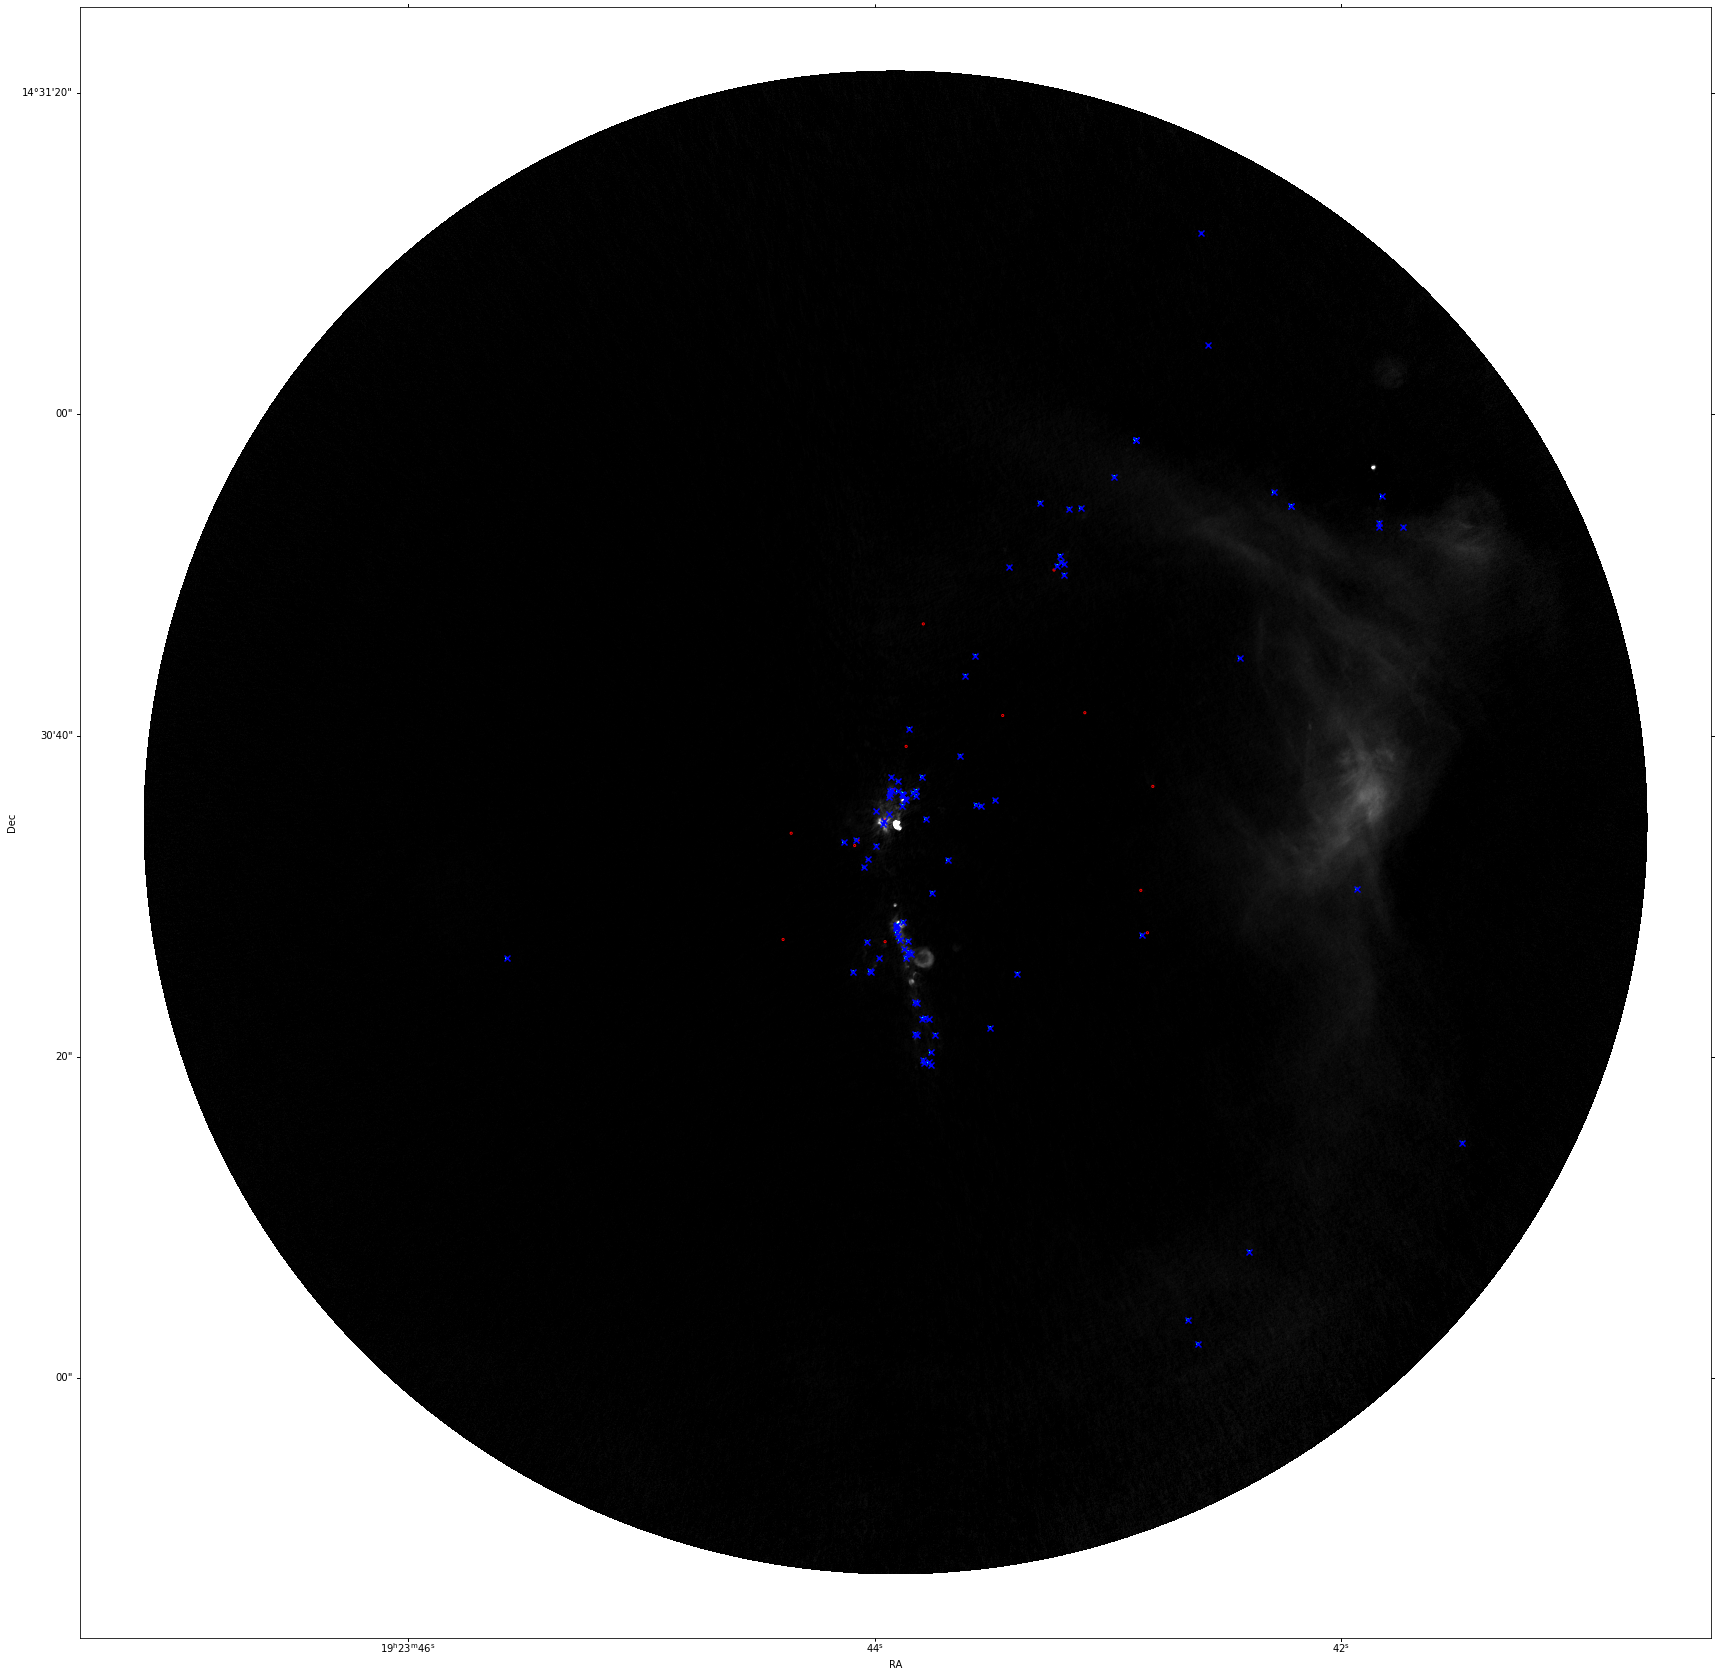

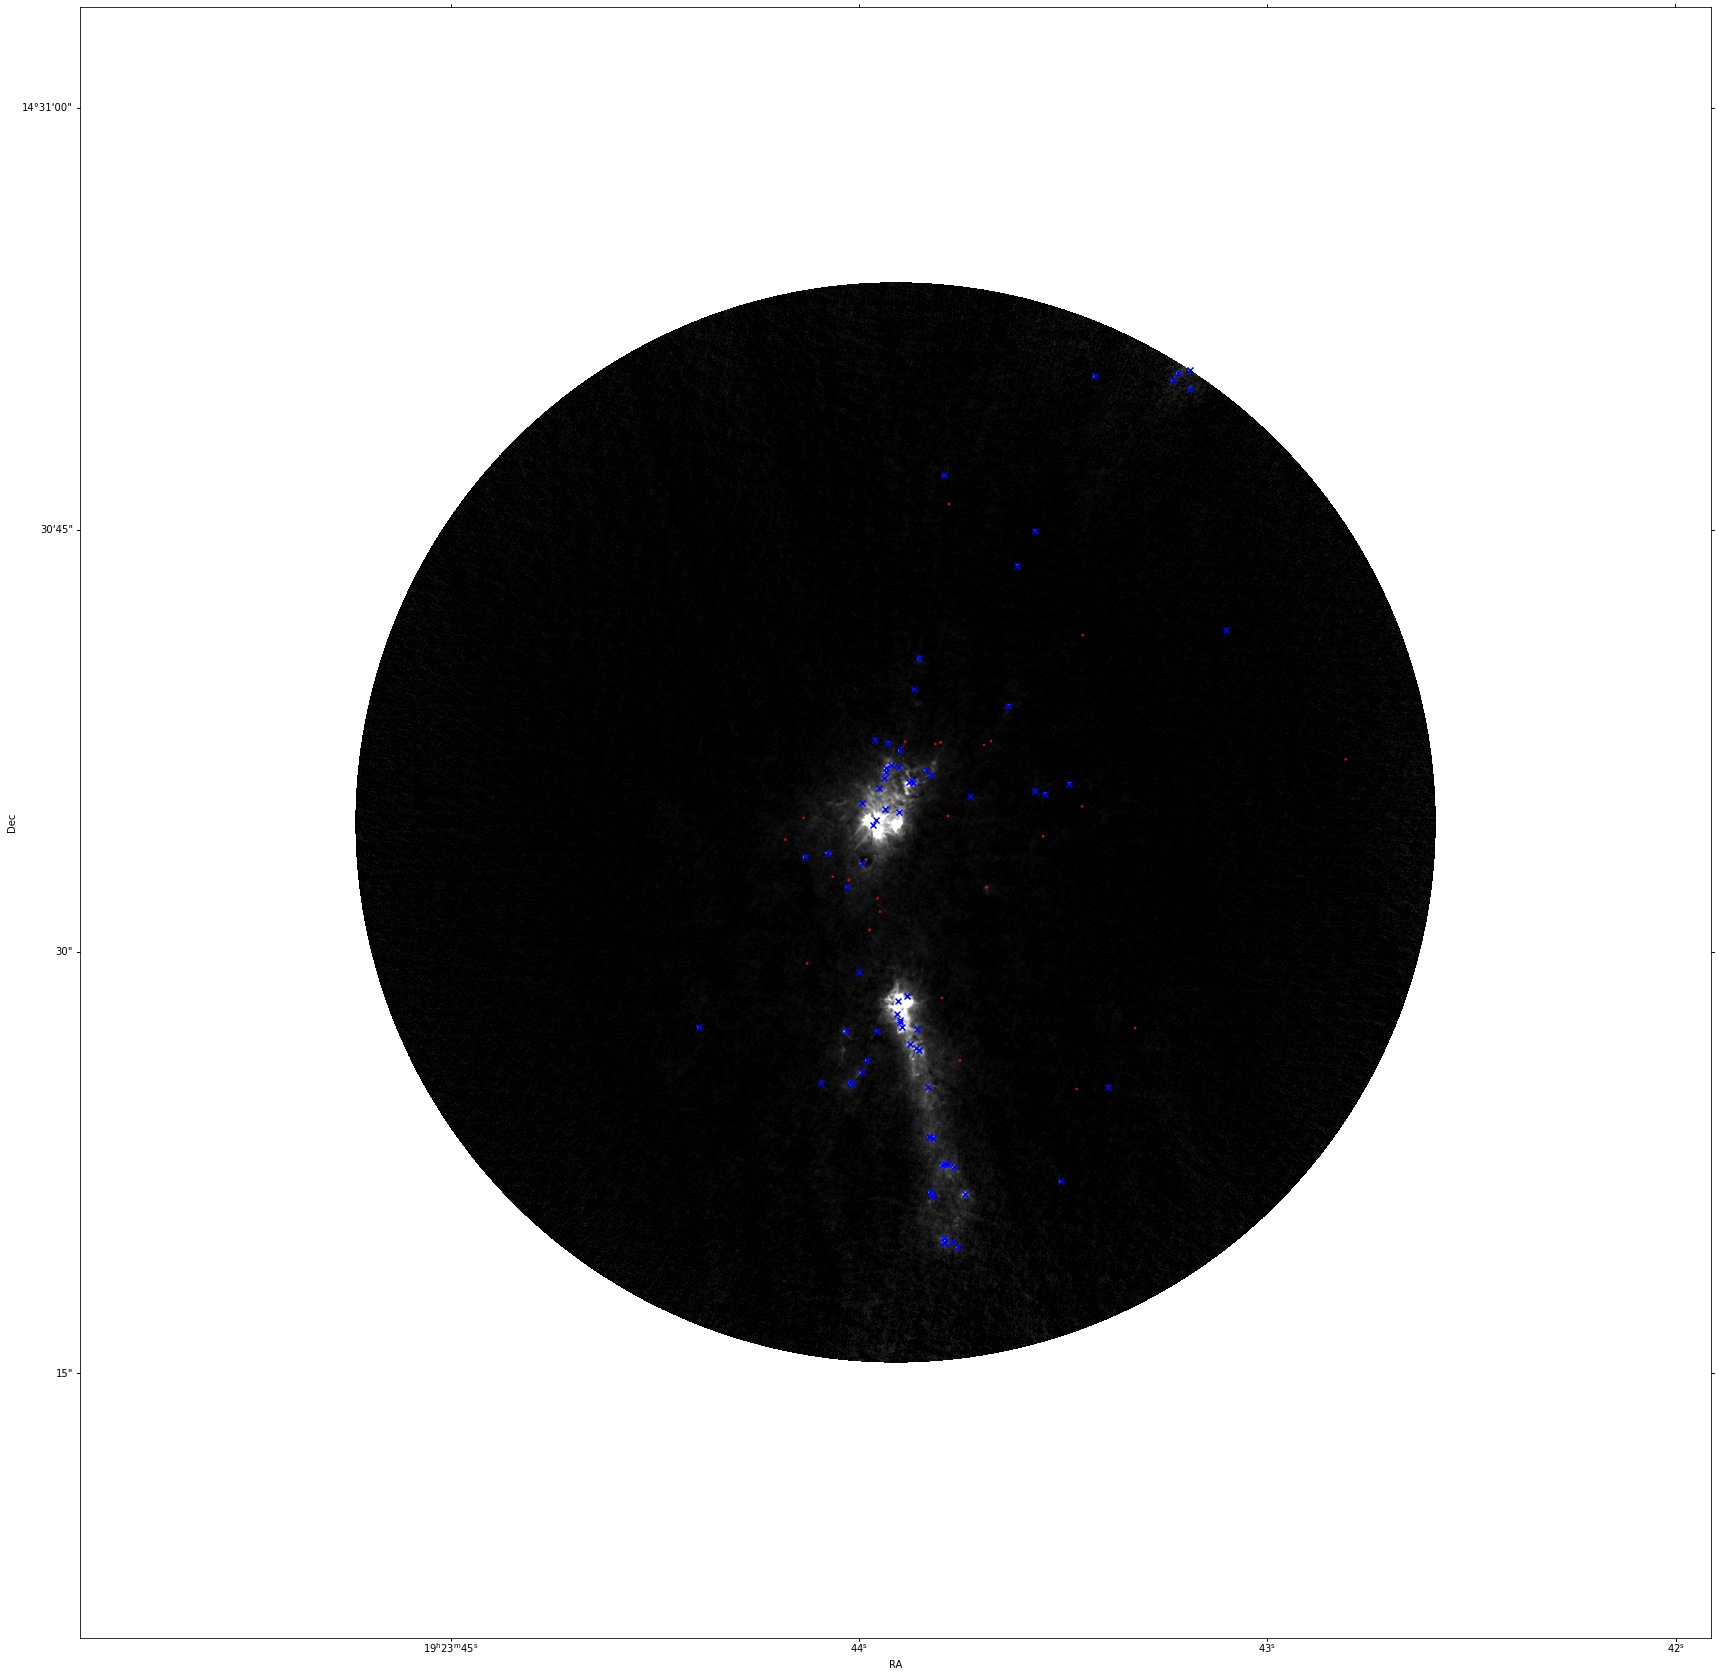

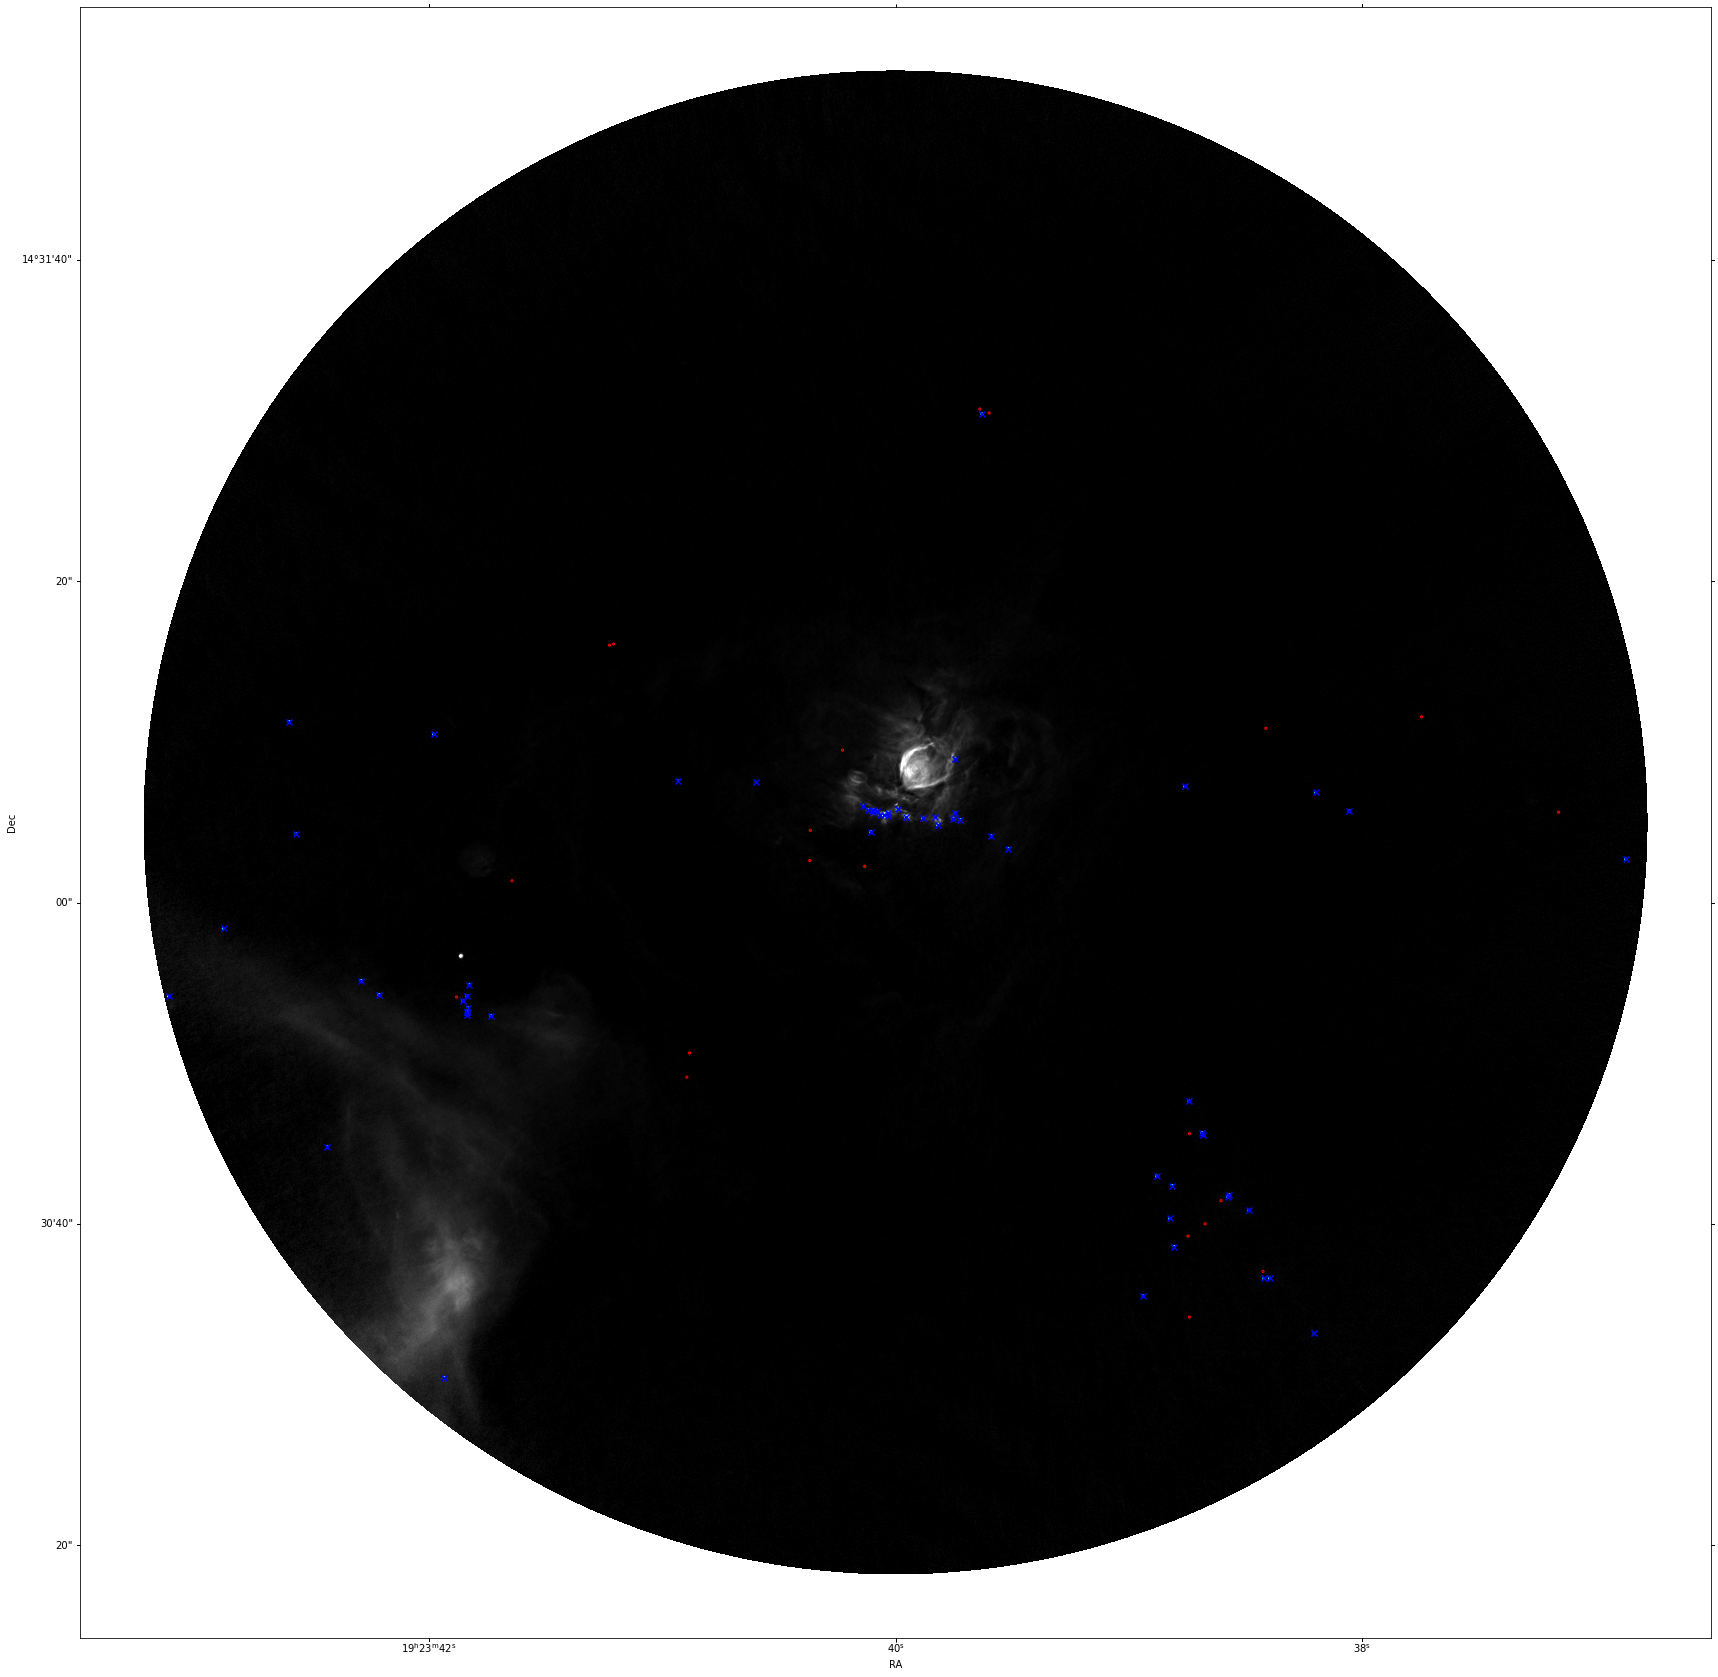

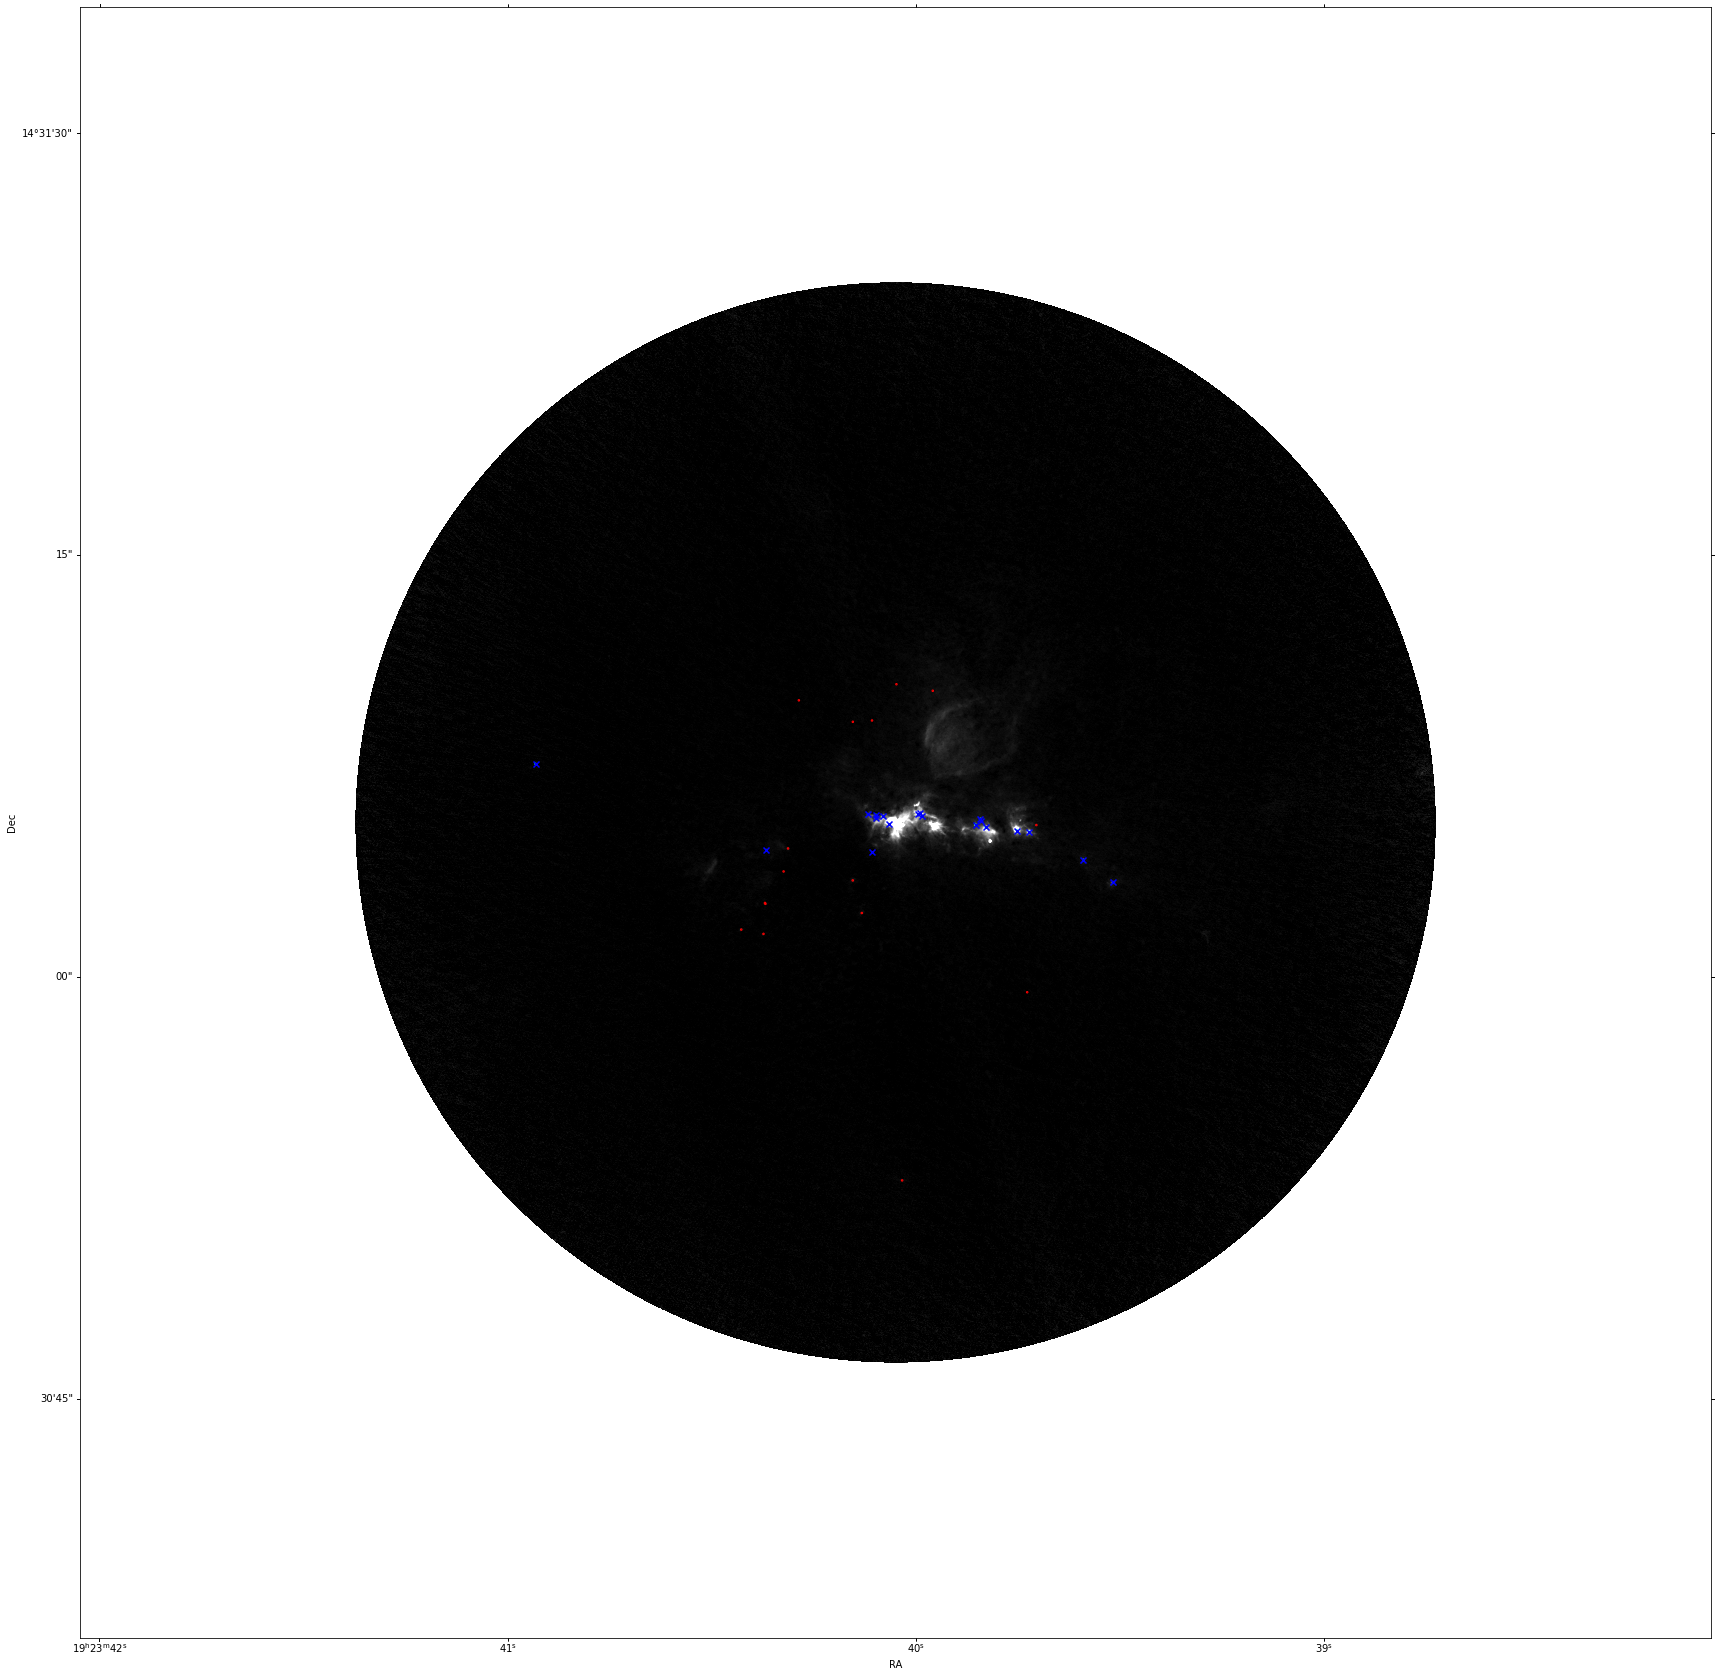

In [10]:
for region in ['W51-E', 'W51-IRS2']:
    for band in ['B3', 'B6']:
        plot_main(region, band)